# Explainable Wind Power Forecast with Lale & Lime

<br>
<br>
<br>

Wind power is one of the most mature and cost-effective renewable technology we have, and it is likely to play a critical role in the transition to a greener and more sustainable energy infrastructure. The major downside of wind power is that it is highly intermittent. An accurate medium-term (up to 48h) wind power forecast can help energy operators to plan ahead and minimize the financial and environmental cost of firing up back-up fossil fuel plant, and help individual farm owners to maximize profit from energy trading.

Wind power forecast, however, is a highly complicated matter, especially for medium- and long-term forecast, as it involves many-step-ahead forecasts. In this project, the forecast is framed as a regression problem to find the relationship between the weather data and the power generation. Weather forecast is generally considered to be accurate up to 72h, so it's well suited for medium-term wind power forecast for business purposes.

The objective of this project to build a semi-automated data science pipeline and an explainable workflow (including preprocessing and feature selection) to select and validate various solutions. 

## Preprocessing data

In [213]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

### About the data:
The dataset contains the hourly wind power generation of Hornsdale Wind Farm (HDWF) in South Australia and the corresponding weather data, through July 2018 to April 2020. Power data is collected from an API provided by the Australian Renewable Energy Mapping Infrastructure Project (AREMI). The original power data is collected in a 5 min interval but is converted to a 1 h interval by averaging all data points within the hour. The hourly weather data is collected from DarkSky API (R.I.P.) at matching time. All data is collected in its local timezone and converted to UTC.

### EDA

In [5]:
df = pd.read_csv('./HDWF2.csv')
df.head(3)

,time,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,power
0,2018-06-30 13:30:00,0.02,0.09,0.85,355.0,0.0,1031.6,2.41,0.0,16.093,108.0,1.81,1.39,0.0
1,2018-06-30 14:30:00,0.01,-0.12,0.85,355.8,0.0,1031.6,2.20,0.0,16.093,107.0,1.89,1.45,0.0
2,2018-06-30 15:30:00,0.01,-0.43,0.84,356.5,0.0,1031.4,1.98,0.0,16.093,105.0,2.00,1.48,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15384 entries, 0 to 15383
Data columns (total 14 columns):
time               15384 non-null object
cloudCover         15384 non-null float64
dewPoint           15384 non-null float64
humidity           15384 non-null float64
ozone              15384 non-null float64
precipIntensity    15384 non-null float64
pressure           15384 non-null float64
temperature        15384 non-null float64
uvIndex            15384 non-null float64
visibility         15384 non-null float64
windBearing        15384 non-null float64
windGust           15384 non-null float64
windSpeed          15384 non-null float64
power              15384 non-null float64
dtypes: float64(13), object(1)
memory usage: 1.6+ MB


In [8]:
df[df.isna().any(1)]

,time,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,power


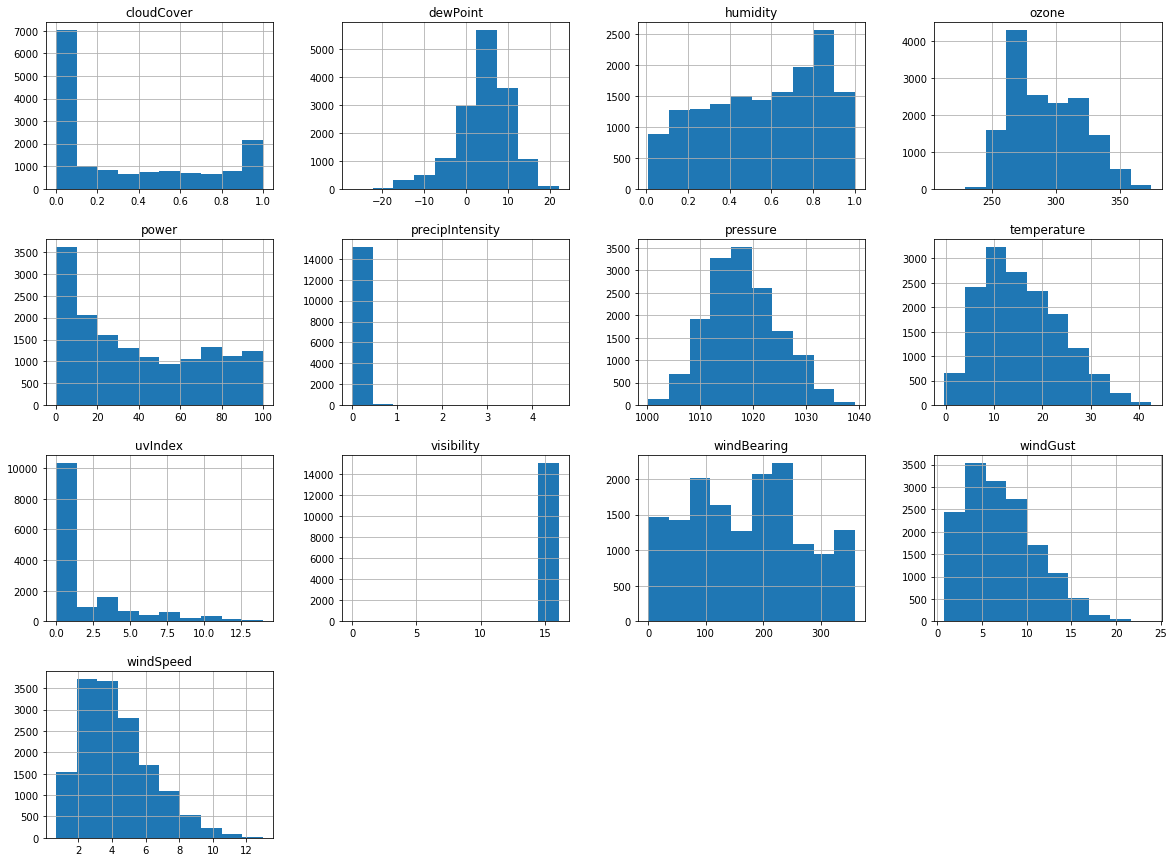

In [9]:
import matplotlib.pyplot as plt
# plot an overview of the distribution of each column
df.hist(figsize=(20,15));

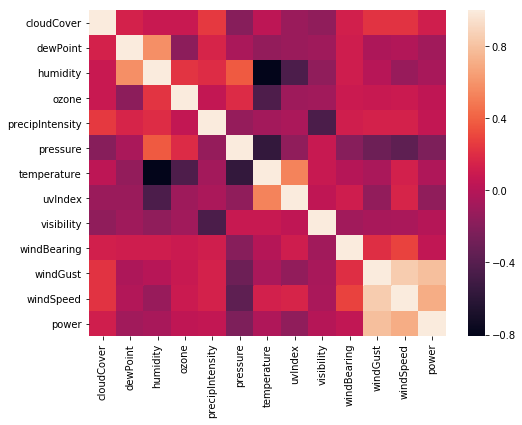

In [10]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr());

The data appears to be rather clean with no missing values or obvious errors. 

Heatmap shows only `windSpeed` and `windGust` is well-correlated with `power`. In addition, the `precipIntensity` and `visibility` columns have very low variance. Feature selection may be needed to improve model performance, which will be part of the pipeline.

## Feature Engineering
The ideal wind power generation is described by the following formula: 

\begin{equation} P = \frac{1}{2} \rho S c_p W_s^3 \end{equation}

where $P$ is the power output, $\rho$ is the density of the air, $S$ is the rotor surface, $c_{p}$ is the power coefficient, and $W_{s}$ is the speed of the wind.

Through the above heatmap and formula, our intuition is that the `windSpeed` and `WindGust` will be the most important predictors.

For feature engineering, the cubic values of `windSpeed` and `WindGust` are then included as features, as well as air density. Density is calculated through temperature, pressure, and dew point/humidity in `cal_density`.

In [11]:
def cal_density(T,P,Td):
    '''
    Calcuate the air density rho (kg/m^3) given temperature T 
    (Celsius C), Pressure P(hPa) and dew point (Celsius C)
    Ref: https://www.gribble.org/cycling/air_density.html
    '''
    
    eso = 6.1078
    c0 = 0.99999683
    c1 = -0.90826951E-2
    c2 = 0.78736169E-4
    c3 = -0.61117958E-6
    c4 = 0.43884187E-8
    c5 = -0.29883885E-10
    c6 = 0.21874425E-12
    c7 = -0.17892321E-14
    c8 = 0.11112018E-16
    c9 = -0.30994571E-19
    p = c0 + Td *(c1 + Td *(c2 + Td *(c3 + Td *(c4 + \
        Td *(c5 + Td *(c6 + Td *(c7 + Td *(c8 + Td *(c9)))))))))
    Pv = eso / p**8
    
    Pd  = P - Pv
    Tk = T + 273.15
    
    Rv = 461.4964
    Rd = 287.0531
    
    rho = ((Pd / (Rd * Tk)) + (Pv / (Rv * Tk)))*100
    
    return rho

df['density'] = cal_density(df.temperature,df.pressure,df.dewPoint)

In [12]:
# Generate the cubic of wind speed and gust
df['windSpeed3'] = df['windSpeed']**3
df['windGust3'] = df['windGust']**3
# windBearing is a rotational data; convert it to its sine and cosine component
df['windSin'] = np.sin(df.windBearing * np.pi / 180.)
df['windCos'] = np.cos(df.windBearing * np.pi / 180.)

df.drop(['time','windBearing'],axis=1,inplace=True)

In [14]:
df.head()

,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windGust,windSpeed,power,density,windSpeed3,windGust3,windSin,windCos
0,0.02,0.09,0.85,355.0,0.0,1031.6,2.41,0.0,16.093,1.81,1.39,0.000000,1.301228,2.685619,5.929741,0.951057,-0.309017
1,0.01,-0.12,0.85,355.8,0.0,1031.6,2.20,0.0,16.093,1.89,1.45,0.000000,1.302265,3.048625,6.751269,0.956305,-0.292372
2,0.01,-0.43,0.84,356.5,0.0,1031.4,1.98,0.0,16.093,2.00,1.48,0.000000,1.303118,3.241792,8.000000,0.965926,-0.258819
3,0.02,-0.76,0.83,357.3,0.0,1031.2,1.78,0.0,16.093,2.15,1.50,0.058333,1.303880,3.375000,9.938375,0.992546,-0.121869
4,0.01,-1.12,0.84,355.8,0.0,1031.4,1.33,0.0,16.093,2.39,1.58,0.300000,1.306344,3.944312,13.651919,0.998630,0.052336


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15384 entries, 0 to 15383
Data columns (total 17 columns):
cloudCover         15384 non-null float64
dewPoint           15384 non-null float64
humidity           15384 non-null float64
ozone              15384 non-null float64
precipIntensity    15384 non-null float64
pressure           15384 non-null float64
temperature        15384 non-null float64
uvIndex            15384 non-null float64
visibility         15384 non-null float64
windGust           15384 non-null float64
windSpeed          15384 non-null float64
power              15384 non-null float64
density            15384 non-null float64
windSpeed3         15384 non-null float64
windGust3          15384 non-null float64
windSin            15384 non-null float64
windCos            15384 non-null float64
dtypes: float64(17)
memory usage: 2.0 MB


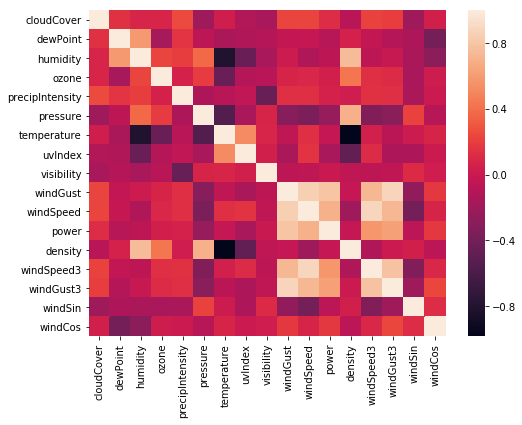

In [16]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr());

## Semi-automated Pipeline with LALE

In [17]:
X = df.drop(['power'],axis=1)
y = df['power']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9,random_state=42)

In [19]:
import lale
from lale.lib.lale import NoOp, Hyperopt

In [20]:
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import StandardScaler as Standard
from xgboost import XGBRegressor as XGB

lale.wrap_imported_operators()

In [209]:
import lale.schemas as schemas
# Custom RFR and XGB operator to save time and reduce overfitting
Custom_RFR = RFR.customize_schema(
    n_estimators=schemas.Int(min=2, max=250),
    max_depth=schemas.Int(min=2, max=12),
    )
Custom_XGB = XGB.customize_schema(
    n_estimators=schemas.Int(min=2, max=250),
    max_depth=schemas.Int(min=2, max=12),
    )

In `planned_pipe`, data is first standardized, then the pipeline will choose to use `PCA` for feature selection or `NoOp`. Then the pipeline will choose among support vector machine, random forest or XGBoost models. The topology of planned pipeline is shown as follows:

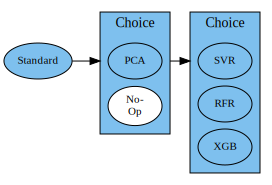

In [210]:
planned_pipe = Standard >> (PCA|NoOp) >> (SVR|Custom_RFR|Custom_XGB)
planned_pipe.visualize()

![alt text](images/planned_pipe.png "Topology of planned pipeline")

In [211]:
trainable_pipe = Hyperopt(estimator = planned_pipe, cv = 3, max_evals = 50, scoring='neg_mean_squared_error')

In [212]:
trained = trainable_pipe.fit(X_train, y_train)

100%|██████████| 50/50 [38:28<00:00, 33.26s/trial, best loss: 172.90396117730788]  


In [216]:
# prints the pipelines with the top 5 lowest loss
trained.summary().loss.sort_values().head()

name
p34    172.903961
p22    176.024841
p44    182.555948
p37    182.785347
p35    184.664394
Name: loss, dtype: float64

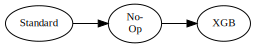

In [237]:
trained.get_pipeline().visualize()

![alt text](images/trained.png "Topology of trained pipeline")

Interestingly, the best estimator didn't do feature selection with `PCA`. Perhaps this is because all the weak predictors show poor multicollinearity per the heat map. This will remain to be explained with packages such as `Lime`.

In [220]:
trained.get_pipeline().pretty_print(show_imports= False, ipython_display= True)
'''
Results:
standard = Standard(with_mean=False, with_std=False)
xgb = XGB(colsample_bylevel=0.7303217366356366, colsample_bytree=0.6725489818299374, learning_rate=0.14324868120461248, max_depth=8, min_child_weight=20, n_estimators=185, reg_alpha=0.07500751793952769, reg_lambda=0.0464726417219788, subsample=0.8939712982118808)
pipeline = standard >> NoOp() >> xgb
'''

```python
standard = Standard(with_mean=False, with_std=False)
xgb = XGB(colsample_bylevel=0.7303217366356366, colsample_bytree=0.6725489818299374, learning_rate=0.14324868120461248, max_depth=8, min_child_weight=20, n_estimators=185, reg_alpha=0.07500751793952769, reg_lambda=0.0464726417219788, subsample=0.8939712982118808)
pipeline = standard >> NoOp() >> xgb
```

In [221]:
from sklearn.metrics import mean_squared_error as mse

In [222]:
print(f'The RMSE of trained pipeline on train set is: {np.sqrt(mse(trained.predict(X_train),y_train))}')
print(f'The RMSE of trained pipeline on test set is: {np.sqrt(mse(trained.predict(X_test),y_test))}')

The RMSE of trained pipeline on train set is: 7.051502546695817
The RMSE of trained pipeline on test set is: 12.352040363907967


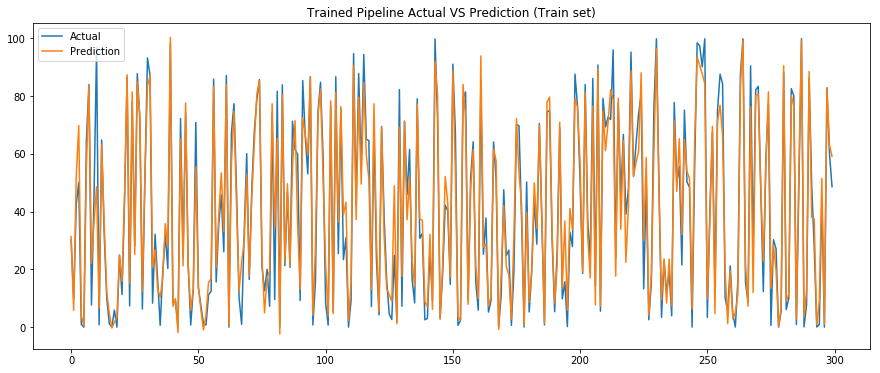

In [235]:
plt.figure(figsize=(15,6))
plt.plot(y_train.values[:300], label='Actual')
plt.plot(trained.predict(X_train)[:300], label='Prediction')
plt.title('Trained Pipeline Actual VS Prediction (Train set)')
plt.legend();

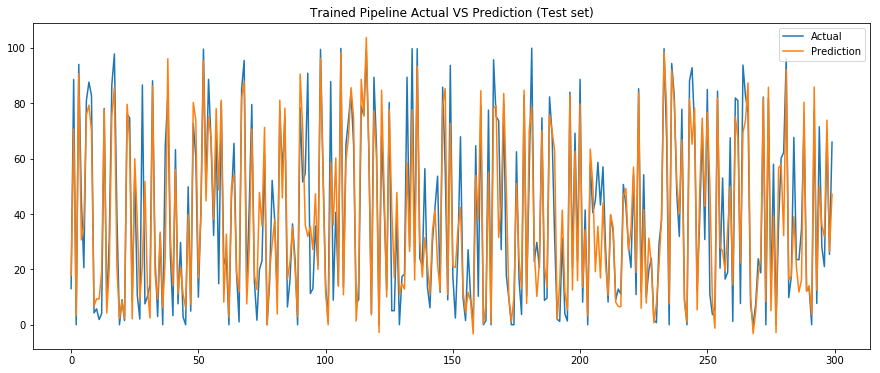

In [239]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values[:300], label='Actual')
plt.plot(trained.predict(X_test)[:300], label='Prediction')
plt.title('Trained Pipeline Actual VS Prediction (Test set)')
plt.legend();

## Explainability with Lime

In [240]:
from aix360.algorithms.lime import LimeTabularExplainer

In [241]:
lime = LimeTabularExplainer(X_test.values, feature_names = X_test.columns, mode='regression')

In [242]:
explainer = lime.explain_instance(X_test.values[42], trained.predict, num_features=16)

In [4]:
explainer.show_in_notebook(show_table = True, show_all = False)

![alt text](images/lime.png "Result of Lime")

The above chart shows an example of how the model makes predictions. The most influential predictors are `windGust`,`windGust3`,`windSpeed` and `windSpeed3`, which validates our intuition. Additionally, the chart validates that the inclusion of the cubic wind during feature engineering is successful, while `density` is less impactful. All predictors except for `visibility` played a role in making the predictions.

## Summary

This project showed a semi-automated data science pipeline and explainable workflow for wind power forecasts using Lale & Lime. This workflow enables data scientists to train, tweak and validate the pipeline with better explainability. In production, the semi-automated nature of the workflow allows data scientists to take real-time weather and power data to tune and re-train models on the fly.

![alt text](images/overview.png "An Overview of the workflow")